# Analysis of Trump's Tweet Data

Data Source: 
http://www.trumptwitterarchive.com/archive

Data Time Range:
01-20-2017 - 11-01-2019

Analysis Procedure:
- Step 1: Text Preprocessing
- Step 2: Topic Modeling--LDA model
- Step 3: Sentiment Analysis
- Step 4: Time series plots

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
np.random.seed(2019)
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, '%m-%d-%Y %H:%M:%S')
tweet = pd.read_csv('tweet-update.csv')
tweet = tweet.dropna(subset=['created_at'])
tweet['created_at'] = tweet['created_at'].apply(dateparser)
tweet = tweet.reset_index(drop=True)

## Step 1: Text Preprocessing

References:
- [Mining Twitter Data with Python](https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/)
- [Friends_text_generator](https://github.com/XuanX111/Friends_text_generator/blob/master/Friends_LDAvis_Xuan_Qi.ipynb)
- [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re
import string

In [5]:
## text pre-processing
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'RT', 'Via']

def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s):
    tokens = [token for token in tokenize(s) if token not in stop and not token.startswith(('#', '@'))]
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token)>2]
    return tokens

In [6]:
# an example of preprocessing
print(tweet.iloc[9]['text'])
print(preprocess(tweet.iloc[9]['text']))

....our great police are being disrespected even with water dumped on them because a Mayor and Governor just don’t “have their backs.” New York’s Finest must be cherished respected and loved. Too many prople are leaving our special New York. Great leaders would work....
['great', 'police', 'disrespected', 'even', 'water', 'dumped', 'mayor', 'governor', 'back', 'new', 'york', 'finest', 'must', 'cherished', 'respected', 'loved', 'too', 'many', 'prople', 'leaving', 'special', 'new', 'york', 'great', 'leader', 'would', 'work']


In [7]:
# preprocess the tokens column
tweet['tokens'] = tweet['text'].apply(preprocess)

In [8]:
# prepare the corpus

def prep_corpus(docs, additional_stopwords=set(), no_below=10, no_above=0.5):
    print('Building dictionary...')
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    print(dictionary)
    dictionary.compactify()
    
    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    return dictionary, corpus

In [9]:
dictionary, corpus = prep_corpus(tweet['tokens'])
MmCorpus.serialize('tweet.mm', corpus)
dictionary.save('tweet.dict')

Building dictionary...
Dictionary(2385 unique tokens: ['account', 'adam', 'call', 'come', 'committee']...)
Building corpus...


## Step 2: Topic Modeling--LDA model

References:
- [Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)
- [Friends_text_generator](https://github.com/XuanX111/Friends_text_generator/blob/master/Friends_LDAvis_Xuan_Qi.ipynb)
- [Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
- [pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)

Results:
- Topic 3 reflects the economic information.
- Topic 6 reflects the trade information.

In [10]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()

In [11]:
%%time
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10)
lda_model.save('tweet.model')
visual = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(visual, 'tweetLDA.html')

CPU times: user 34.2 s, sys: 88.5 ms, total: 34.3 s
Wall time: 34.5 s


In [14]:
%%time
lda_model2 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10)
lda_model2.save('tweet2.model')
visual2 = gensimvis.prepare(lda_model2, corpus, dictionary)
pyLDAvis.save_html(visual2, 'tweetLDA2.html')

CPU times: user 48.1 s, sys: 508 ms, total: 48.6 s
Wall time: 2min 14s


In [15]:
%%time
lda_model3 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10)
lda_model3.save('tweet3.model')
visual3 = gensimvis.prepare(lda_model3, corpus, dictionary)
pyLDAvis.save_html(visual3, 'tweetLDA3.html')

CPU times: user 43.3 s, sys: 238 ms, total: 43.6 s
Wall time: 1min 56s


In [16]:
%%time
lda_model4 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10)
lda_model4.save('tweet4.model')
visual4 = gensimvis.prepare(lda_model4, corpus, dictionary)
pyLDAvis.save_html(visual4, 'tweetLDA4.html')

CPU times: user 44.4 s, sys: 268 ms, total: 44.7 s
Wall time: 2min 10s


In [17]:
%%time
lda_model5 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=20)
lda_model5.save('tweet5.model')
visual5 = gensimvis.prepare(lda_model5, corpus, dictionary)
pyLDAvis.save_html(visual5, 'tweetLDA5.html')

CPU times: user 45 s, sys: 319 ms, total: 45.3 s
Wall time: 2min 5s


In [18]:
%%time
lda_model6 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=40)
lda_model6.save('tweet6.model')
visual6 = gensimvis.prepare(lda_model6, corpus, dictionary)
pyLDAvis.save_html(visual6, 'tweetLDA6.html')

CPU times: user 45 s, sys: 303 ms, total: 45.3 s
Wall time: 2min


In [19]:
%%time
lda_model7 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=100)
lda_model7.save('tweet7.model')
visual7 = gensimvis.prepare(lda_model7, corpus, dictionary)
pyLDAvis.save_html(visual7, 'tweetLDA7.html')

CPU times: user 42.8 s, sys: 160 ms, total: 43 s
Wall time: 1min 56s


In [20]:
%%time
lda_model8 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=200)
lda_model8.save('tweet8.model')
visual8 = gensimvis.prepare(lda_model8, corpus, dictionary)
pyLDAvis.save_html(visual8, 'tweetLDA8.html')

CPU times: user 45.6 s, sys: 370 ms, total: 46 s
Wall time: 2min 2s


In [21]:
%%time
lda_model9 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=300)
lda_model9.save('tweet9.model')
visual9 = gensimvis.prepare(lda_model9, corpus, dictionary)
pyLDAvis.save_html(visual9, 'tweetLDA9.html')

CPU times: user 42.7 s, sys: 144 ms, total: 42.9 s
Wall time: 1min 53s


In [22]:
%%time
lda_model10 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=400)
lda_model10.save('tweet10.model')
visual10 = gensimvis.prepare(lda_model10, corpus, dictionary)
pyLDAvis.save_html(visual10, 'tweetLDA10.html')

CPU times: user 45.3 s, sys: 425 ms, total: 45.7 s
Wall time: 2min 8s


In [23]:
%%time
lda_model11 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=500)
lda_model11.save('tweet11.model')
visual11 = gensimvis.prepare(lda_model11, corpus, dictionary)
pyLDAvis.save_html(visual11, 'tweetLDA11.html')

CPU times: user 44 s, sys: 371 ms, total: 44.4 s
Wall time: 2min 18s


In [24]:
%%time
lda_model12 = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=10, random_state=600)
lda_model12.save('tweet12.model')
visual12 = gensimvis.prepare(lda_model12, corpus, dictionary)
pyLDAvis.save_html(visual12, 'tweetLDA12.html')

CPU times: user 43.5 s, sys: 232 ms, total: 43.7 s
Wall time: 1min 56s


- The trade topic by tweet8.model is pretty good, while the economic topic by tweet5.model is pretty good. The combination of tweet11.model is very good. So use tweet11.model. And combine trade and economy together.
- In the plot, topic 3 is trade relevant, and topic 8 is economy relevant. In the model, topic 29 is trade relevant, and topic 19 is economy relevant.

In [25]:
# find the corresponding topic number
for idx, topic in lda_model11.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.042*"tonight" + 0.032*"man" + 0.030*"enjoy" + 0.025*"interviewed" + 0.024*"presidential" + 0.024*"time" + 0.024*"isi" + 0.023*"veteran" + 0.022*"congressman" + 0.021*"bob"
Topic: 1 
Words: 0.072*"russia" + 0.064*"collusion" + 0.046*"hillary" + 0.046*"campaign" + 0.041*"russian" + 0.036*"crooked" + 0.034*"democrat" + 0.029*"election" + 0.027*"amp" + 0.019*"the"
Topic: 2 
Words: 0.053*"congratulation" + 0.047*"bill" + 0.040*"great" + 0.034*"work" + 0.026*"friend" + 0.026*"proud" + 0.024*"member" + 0.023*"highest" + 0.022*"reform" + 0.020*"kim"
Topic: 3 
Words: 0.101*"american" + 0.049*"people" + 0.036*"life" + 0.033*"the" + 0.032*"amp" + 0.030*"true" + 0.026*"family" + 0.020*"statement" + 0.018*"energy" + 0.017*"making"
Topic: 4 
Words: 0.075*"history" + 0.045*"john" + 0.036*"the" + 0.028*"greatest" + 0.021*"biggest" + 0.021*"chuck" + 0.021*"word" + 0.018*"read" + 0.016*"more" + 0.015*"perhaps"
Topic: 5 
Words: 0.204*"trump" + 0.172*"president" + 0.064*"obama" + 0.050*

In [26]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=tweet['text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model11, corpus=corpus, texts=tweet['text'])
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [45]:
idx = df_dominant_topic['Document_No'][(df_dominant_topic.Dominant_Topic == 29.0) | (df_dominant_topic.Dominant_Topic == 19.0)]
trade_economy = tweet.iloc[idx]

## Step 3: Sentiment Analysis

References: 
- [Trump, Tweets, and Trade](https://towardsdatascience.com/trump-tweets-and-trade-96ac157ef082)
- [Simplifying Sentiment Analysis using VADER in Python](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f).

Note:
- Positive Sentiment Signal
    - Signal occurs before market opens: buy at open and sell at close
    - Signal occurs during market hours: buy at close and sell at tomorrow’s close
    - Signal occurs after hours: buy at tomorrow’s open and sell at tomorrow’s close
- Negative Sentiment Signal
    - Signal occurs before market opens: sell at open and return to 100% SPY exposure at close
    - Signal occurs during market hours: sell at close and return to 100% SPY exposure at tomorrow’s close
    - Signal occurs after hours: sell at tomorrow’s open and return to 100% SPY exposure at tomorrow’s close

In [47]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
trade_economy['sentiment'] = trade_economy['tokens'].apply(lambda x: analyser.polarity_scores(' '.join(x))['compound'])

In [48]:
trade_economy.to_csv('trade-economy-tweet.csv', index=False)

## Step 4: Time series plots

References:
- [Mining Twitter Data with Python](https://marcobonzanini.com/2015/04/01/mining-twitter-data-with-python-part-5-data-visualisation-basics/)

If we organise the frequencies into temporal buckets, we could observe how Twitter users react to real-time events.

In [52]:
## plot for trade-economy data
dates = []
# f is the file pointer to the JSON data set
for i in range(trade_economy.shape[0]):
    tweet = trade_economy.iloc[i]
    dates.append(tweet['created_at'])

# a list of "1" to count the hashtags
ones = [1]*len(dates)
# the index of the series
idx = pd.DatetimeIndex(dates)
# the actual series (at series of 1s for the moment)
freq = pd.Series(ones, index=idx)
 
# Resampling / bucketing
per_day = freq.resample('D').sum().fillna(0)

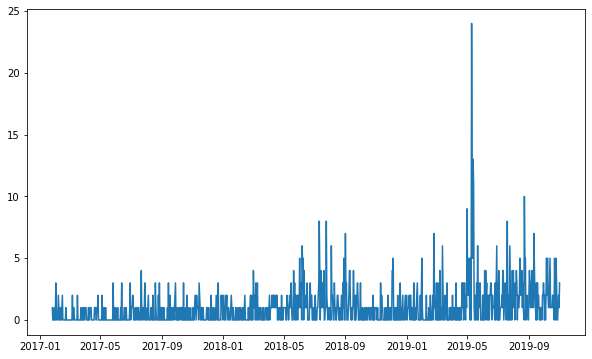

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(per_day)